# Los Angeles County Urban Tree Canopy and Historical Redlining  
#### Due 2021-11-19
#### EDS 220: Remote Sensing 

# Authors
- [Paloma Cartwright](https://palomacartwright.github.io), UC Santa Barbara (palomacartwright@bren.ucsb.edu)
- [Halina Do-Linh](hdolinh.github.io/), UC Santa Barbara (halina@bren.ucsb.edu)
- [Mia Forsline](https://miaforsline.github.io/), UC Santa Barbara (mforsline@bren.ucsb.edu)

# Table of Contents 
[1. Purpose](#purpose)

[2. Dataset Description](#data)

[3. Data I/O](#load) - Paloma 
- [3.1. Load LA County Shapefile](#shp)
- [3.2. Load TreePeople Urban Tree Canopy Data](#can)
- [3.3. Load Historical Redlining Data](#redlining)

[4. Metadata Display and Basic Visualization](#display) - Mia 
- [4.1. Canopy Data Wrangling](#wrangle)
- [4.2. Plot Percentage Tree Canopy](#canplot)
- [4.3. Plot Historical Redlining](#redplot)
- [Bonus: Plot Impervious Surfaces from LA County Data](#imperv)

[5. Use Case Example](#usecase) - Halina 
- [5.1. Composite Map: canopy cover and redlining](#composite)

[6. Create Binder Environment](#binder)

[7. References](#references)

<a id='purpose'></a> 
## Purpose
This notebook aims to explore the relationship between the percentage of modern tree canopy cover and historical 1939 redlining in Los Angeles County.

According to the USDA Forest Service (Grove & Locke, 2011), urban tree-canopy cover provides vital ecosystem services such as reducing summer peak temperatures and air pollution as well as providing habitat for wildlife. The presence of trees also enhances property values and offers aesthetic benefits. More importantly, by reducing summer heat temperatures, trees can mitigate the urban heat island effect, in which urban climates are warmer than the surrounding rural areas (Oke 1981).

The development of modern green spaces is known to be correlated with historical redlining practices (Nardone et al. 2021). "Redlining" is the term for historic race-based exclusionary practices in real estate from racial steering to racial barring in many suburbs and developments in America during the 1930s. Areas were graded A ("best") through D ("hazardous") to guide bank lending policies, with predominantly White and/or affluent areas often receiving grades of A or B (Krieger et al. 2020). These actions all contributed to racial segregation and shaped the way America looks today.

To examine the link between modern urban tree cover and historical redlining, we map the percentage of tree canopy cover in 2014, the grades assigned to residential areas by the federal government's Home Owners' Loan Corporation, and a composite map of both tree canopy cover and grades. We expect historical residential areas with the highest grade of A to demonstrate the highest percentage of modern tree canopy cover.

<a id='data'></a> 
## Dataset Description
### 1. [Tree Canopy in Urban and Non-Urban LA County (2014)](https://data.lacounty.gov/Sustainability/Tree-Canopy-in-Urban-and-Non-Urban-LA-County-2014-/kf6c-hxgf)
This dataset contains LA County tree canopy data from the LA County tree canopy data from TreePeople and the University of Vermont as well as LA County land cover data and 2014 imagery from the Los Angeles Regional Imagery Acquisition Consortium. The tree canopy data are a CSV file with polygon geometries and tree canopy cover percentages for different census blocks in LA County. The land cover data are shapefiles. We retrieved the data from the [County of Los Angeles Open Data](https://data.lacounty.gov/). One issue with this data is the lack of descriptive metadata. As a result, we focused on analyzing self-explanatory variables such as tree canopy (`'Can_P'`) and impervious surfaces (`'imperv_p'`). 

### 2. [Mapping Inequality](https://dsl.richmond.edu/panorama/redlining/#loc=5/39.1/-94.58&text=downloads)
This dataset contains shapefiles of the Home Owners' Loan Corporation map for Los Angeles in 1939 illustrating the grades (A-D) for each region. We retrieved the data from the University of Richmond's [Mapping Inequality project](https://dsl.richmond.edu/panorama/redlining/#loc=5/39.1/-94.58&text=downloads). All of *Mapping Inequality*'s spatial, textual, and other data are licensed under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License. One issue with this dataset is that the historical spatial extent does not match up perfectly with modern LA County. There are a lot of gaps where the tree canopy cover and redlining data do not align, making it somewhat difficult to draw conclusions. 

<a id='load'></a>
# Dataset I/O 

## Importing all necessary packages 

In [1]:
import geopandas as gpd 
import pandas as pd
import rasterio as rio
from rasterio.plot import show
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import contextily as ctx
%matplotlib inline

<a id='shp'></a> 
## Load the LA County Shapefile  

Read in LA County shapefile from the data folder using `geopandas` as area of interest and set the correct CRS. 

In [2]:
# Read in the LA County shapefile
aoiFile = "data/Tree_Canopy_LA/geo_export_36bb7874-a8f8-4d1c-b3f3-23eca2fca1af.shp"
aoiData = gpd.read_file(aoiFile)

# Set the CRS to WGS 84
# Allow_override = True because it was set to WGS84(DD) 
# This is not exactly the same as the others so we changed it

AOI = aoiData.set_crs("EPSG:4326", allow_override = True)
AOI.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<a id='can'></a>
## Load TreePeople Urban Tree Canopy Data 

Read in the csv containing tree canopy data from the data folder using `geopandas` and set the correct CRS.

In [3]:
# Read in LA County Tree Canopy csv file 
treeCanopyFile = 'data/Tree_Canopy_in_Urban_and_Non-Urban_LA_County__2014_.csv'
treeCanopyLA = gpd.read_file(treeCanopyFile)

# Set the CRS to WGS 84
tcLA = treeCanopyLA.set_crs('EPSG:4326')
tcLA.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<a id='redlining'></a>
## Load Historical Redlining Data 

Read in the Historical Redlining File data from the data folder using `geopandas` and set the correct CRS.

In [29]:
# Read in the redlining data 
redliningFile = 'data/redlining/CALosAngeles1939/cartodb-query.shp'
red = gpd.read_file(redliningFile)

# Set the crs 
redlining = red.set_crs('EPSG:4326')
redlining.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<a id='display'></a>
# Metadata Display and Basic Visualization

<a id='wrangle'></a>
## Bootstrap the Canopy Geometries

Convert latitudinal and longitudinal data points to spatial geometries.

In [5]:
# Check the contents of the TreeCanopy Data
# Note tcLA (tree canopy LA) has a `the_geom` column 
# Note tcLA has an empty `geometry` column
tcLA.head()

the_geom OBJECTID       GEOID10  \
0  MULTIPOLYGON (((-118.44622000110732 33.9842599...      307  060377029014   
1  MULTIPOLYGON (((-118.70401700066061 34.0809309...      801  060378004101   
2  MULTIPOLYGON (((-118.69364100097145 34.0776949...      802  060378005041   
3  MULTIPOLYGON (((-118.56733961261031 34.0413904...      803  060378005062   
4  MULTIPOLYGON (((-117.84478600114087 34.6458369...      805  060379001032   

    CTBG10    CT10 AreaSqMil LABEL  FIP10 FIP10RV          CDP_NAME  ...  \
0  7029014  702901    0.8425  BG 4  45806   99037    Marina del Rey  ...   
1  8004101  800410   14.4154  BG 1          99037                    ...   
2  8005041  800504    8.2425  BG 1          99037                    ...   
3  8005062  800506    0.1243  BG 2          45246                    ...   
4  9001032  900103     3.567  BG 2  39612   99037  Lake Los Angeles  ...   

          Soil_P        Water_P        Build_P         Road_P        Paved_P  \
0   1.6527313537   7.5993867462  8.17486383171  7.37678656067  25.3708605589   
1   21.115381057  0.02800440518  0.74389284843  1.97793985737  0.92139887924   
2  27.9550069647  0.49547707747  2.09680991148  2.96657388971  2.26579694363   
3  35.7175055671  0.47872772023  16.8393151759  23.7677945167  14.1296802171   
4  89.3109528519              0  1.77681768231    4.333439534  0.30396580989   

         Shrub_P         Perv_P       Imperv_P  \
0  3.52682720594  59.0774890487  40.9225109513   
1  38.1627106387   96.356768415  3.64323158505   
2  32.8025403387  92.6708192552  7.32918074483   
3  0.82402473877  45.2632100902  54.7367899098   
4  1.20483307759  93.5857769738   6.4142230262   

                                 layer geometry  
0  la_county_nonurban_2010_blockgroups     None  
1  la_county_nonurban_2010_blockgroups     None  
2  la_county_nonurban_2010_blockgroups     None  
3  la_county_nonurban_2010_blockgroups     None  
4  la_county_nonurban_2010_blockgroups     None  

[5 rows x 51 columns]

In [6]:
# Note tcLA's `Can_P` column 
tcLA.columns

Index(['the_geom', 'OBJECTID', 'GEOID10', 'CTBG10', 'CT10', 'AreaSqMil',
       'LABEL', 'FIP10', 'FIP10RV', 'CDP_NAME', 'CITYNAME', 'COMMNAME',
       'TC_ID', 'Shape_Leng', 'Shape_Area', 'OBJECTID_1', 'TC_ID_1', 'TC_E_A',
       'TC_Pv_A', 'TC_Land_A', 'TC_Pi_A', 'TC_P_A', 'TC_E_P', 'TC_Pv_P',
       'TC_P_P', 'TC_Pi_P', 'OBJECTID_2', 'TC_ID_12', 'Can_A', 'Grass_A',
       'Soil_A', 'Water_A', 'Build_A', 'Road_A', 'Paved_A', 'Shrub_A',
       'Perv_A', 'Imperv_A', 'Total_A', 'Can_P', 'Grass_P', 'Soil_P',
       'Water_P', 'Build_P', 'Road_P', 'Paved_P', 'Shrub_P', 'Perv_P',
       'Imperv_P', 'layer', 'geometry'],
      dtype='object')

In [8]:
# Move the geometry info from `the_geom` column to new `geometry` column 
tcLA['geometry'] = tcLA['the_geom']

# Create a GeoSeries from the Well Known Text
tcLA['geometry'] = gpd.GeoSeries.from_wkt(tcLA['geometry'])

# Create a GeoDataFrame from the GeoSeries
tcLA_gdf = gpd.GeoDataFrame(tcLA, geometry='geometry')

# Check CRS is in WGS 84 
tcLA_gdf.crs

In [31]:
# Ensure % canopy cover (Can_P) is a numeric column 
tcLA_gdf['Can_P'] = pd.to_numeric(tcLA['Can_P'])

# Ensure you can calculate a mean/max/etc. 
tcLA_gdf['Can_P'].max()

# Check `Can_P` is a numeric (float64)
# Check `geometry` is a geometry
print(tcLA_gdf.dtypes)

the_geom        object
OBJECTID        object
GEOID10         object
CTBG10          object
CT10            object
AreaSqMil       object
LABEL           object
FIP10           object
FIP10RV         object
CDP_NAME        object
CITYNAME        object
COMMNAME        object
TC_ID           object
Shape_Leng      object
Shape_Area      object
OBJECTID_1      object
TC_ID_1         object
TC_E_A          object
TC_Pv_A         object
TC_Land_A       object
TC_Pi_A         object
TC_P_A          object
TC_E_P          object
TC_Pv_P         object
TC_P_P          object
TC_Pi_P         object
OBJECTID_2      object
TC_ID_12        object
Can_A           object
Grass_A         object
Soil_A          object
Water_A         object
Build_A         object
Road_A          object
Paved_A         object
Shrub_A         object
Perv_A          object
Imperv_A        object
Total_A         object
Can_P          float64
Grass_P         object
Soil_P          object
Water_P         object
Build_P    

<a id='canplot'></a>
## Plot Percentage Canopy Cover 

AttributeError: 'GeoDataFrame' object has no attribute 'explore'

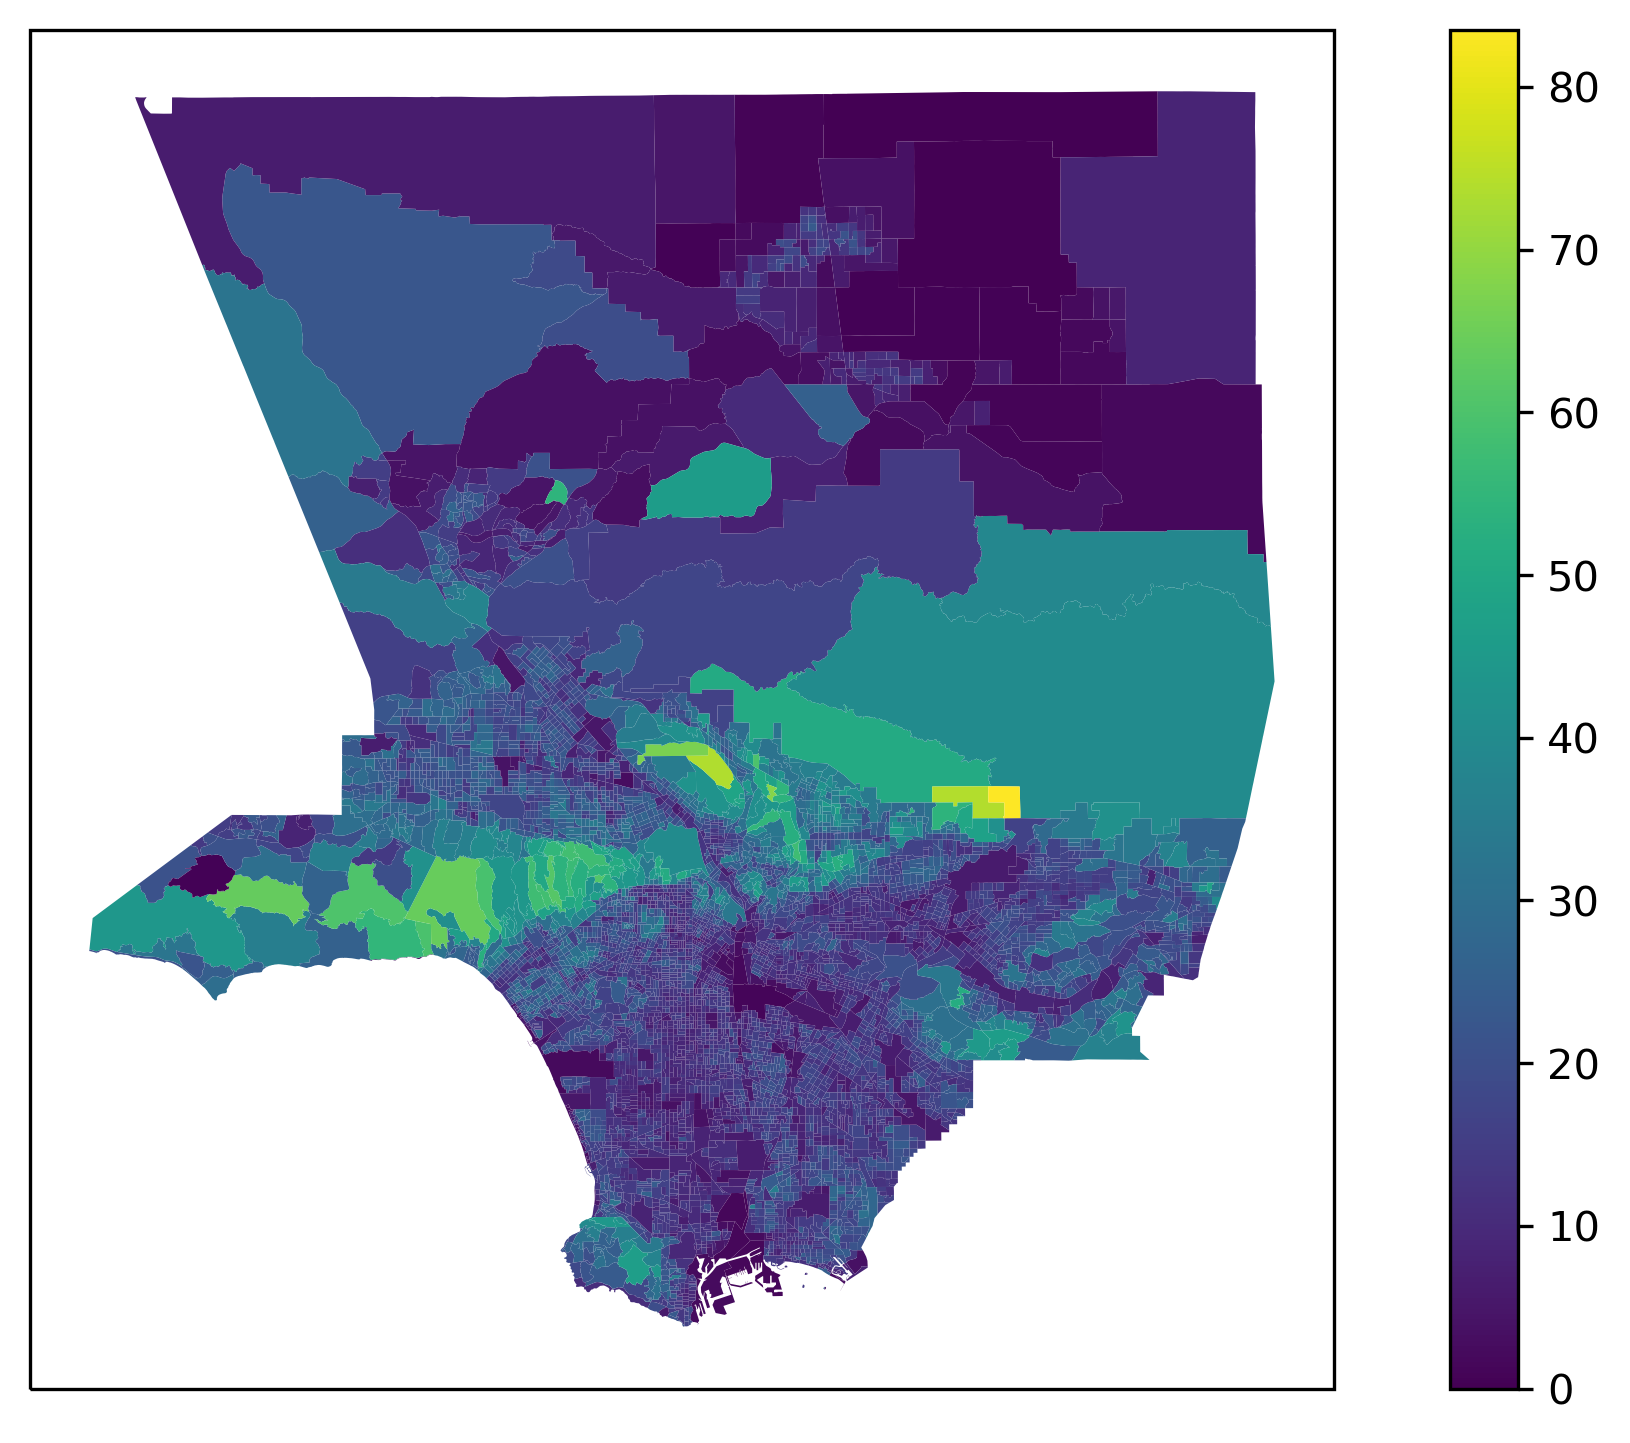

In [18]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize = (10, 6), dpi = 300)
ax = plt.axes(projection = proj)

tcLA.plot('Can_P', ax = ax, legend = True)
tcLAt = tcLA.explore('Can_P')

# Add basemap 
ctx.add_basemap(ax, crs = 'EPSG:4326', source=ctx.providers.CartoDB.Positron); 

# Add title and axes titles 
plt.title('% Canopy Cover in Los Angeles County for 2014')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


### Calculate Canopy Statistics

In [20]:
can_mean = tcLA['Can_P'].mean()
can_max = tcLA['Can_P'].max()
can_min = tcLA['Can_P'].min()

print('Average % canopy cover in Los Angeles County in 2014:', round(can_mean, 2), '%')
print('Max % canopy cover in Los Angeles County in 2014:', round(can_max, 2), '%')
print('Min % canopy cover in Los Angeles County in 2014:', round(can_min, 2), '%')

Average % canopy cover in Los Angeles County in 2014: 17.92 %
Max % canopy cover in Los Angeles County in 2014: 83.53 %
Min % canopy cover in Los Angeles County in 2014: 0.0 %


# 1939 Historical Redlining in LA County 
Check the geometries are intact before plotting

In [15]:
red.head()

name holc_id holc_grade                                           geometry
0  None      A1          A  POLYGON ((-118.45744 34.15201, -118.44784 34.1...
1  None     A10          A  POLYGON ((-118.11151 34.18311, -118.10943 34.1...
2  None     A11          A  POLYGON ((-118.11300 34.15985, -118.11301 34.1...
3  None     A12          A  POLYGON ((-118.17123 34.12776, -118.17084 34.1...
4  None     A13          A  MULTIPOLYGON (((-118.17458 34.14194, -118.1735...

<a id='redplot'></a>
## Plot redlining map 

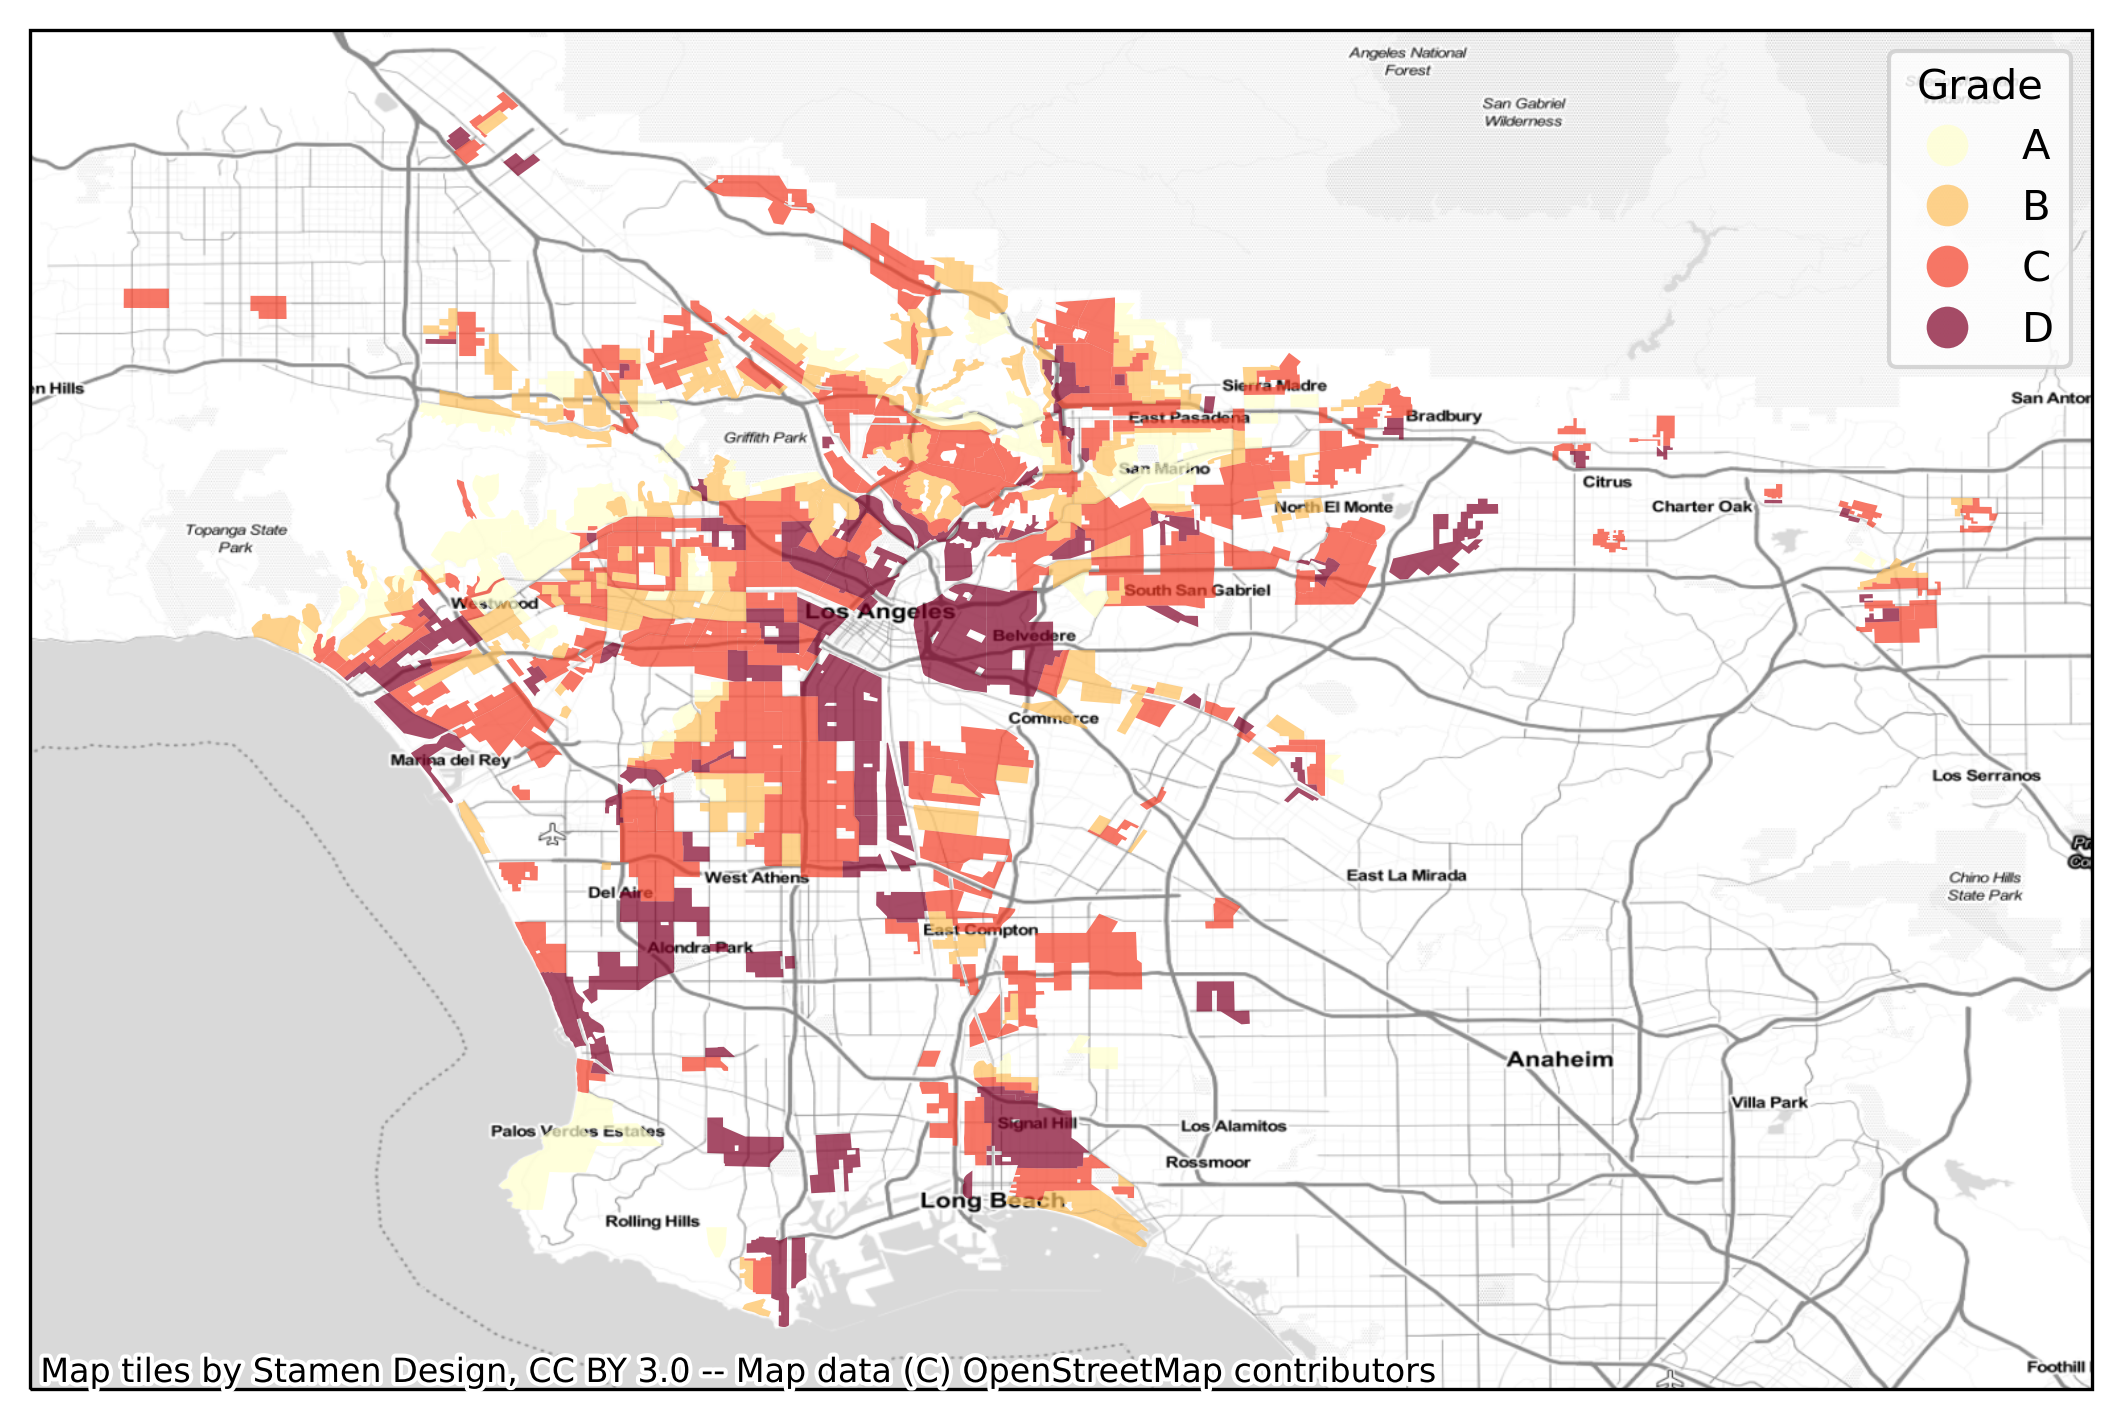

In [24]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize = (10, 6), dpi = 300)
ax = plt.axes(projection = proj)

# tcLA.plot(column = 'Can_P' ax = ax)
red.plot(column = 'holc_grade', ax = ax, legend = True, cmap = 'YlOrRd', 
         legend_kwds = {'title': 'Grade'}, alpha = 0.7)

# Add basemap 
ctx.add_basemap(ax, crs = 'EPSG:4326', source = ctx.providers.Stamen.TonerLite); 

<a id='imperv'></a>
## Plot impervious surfaces

Text(0, 0.5, 'Latitude')

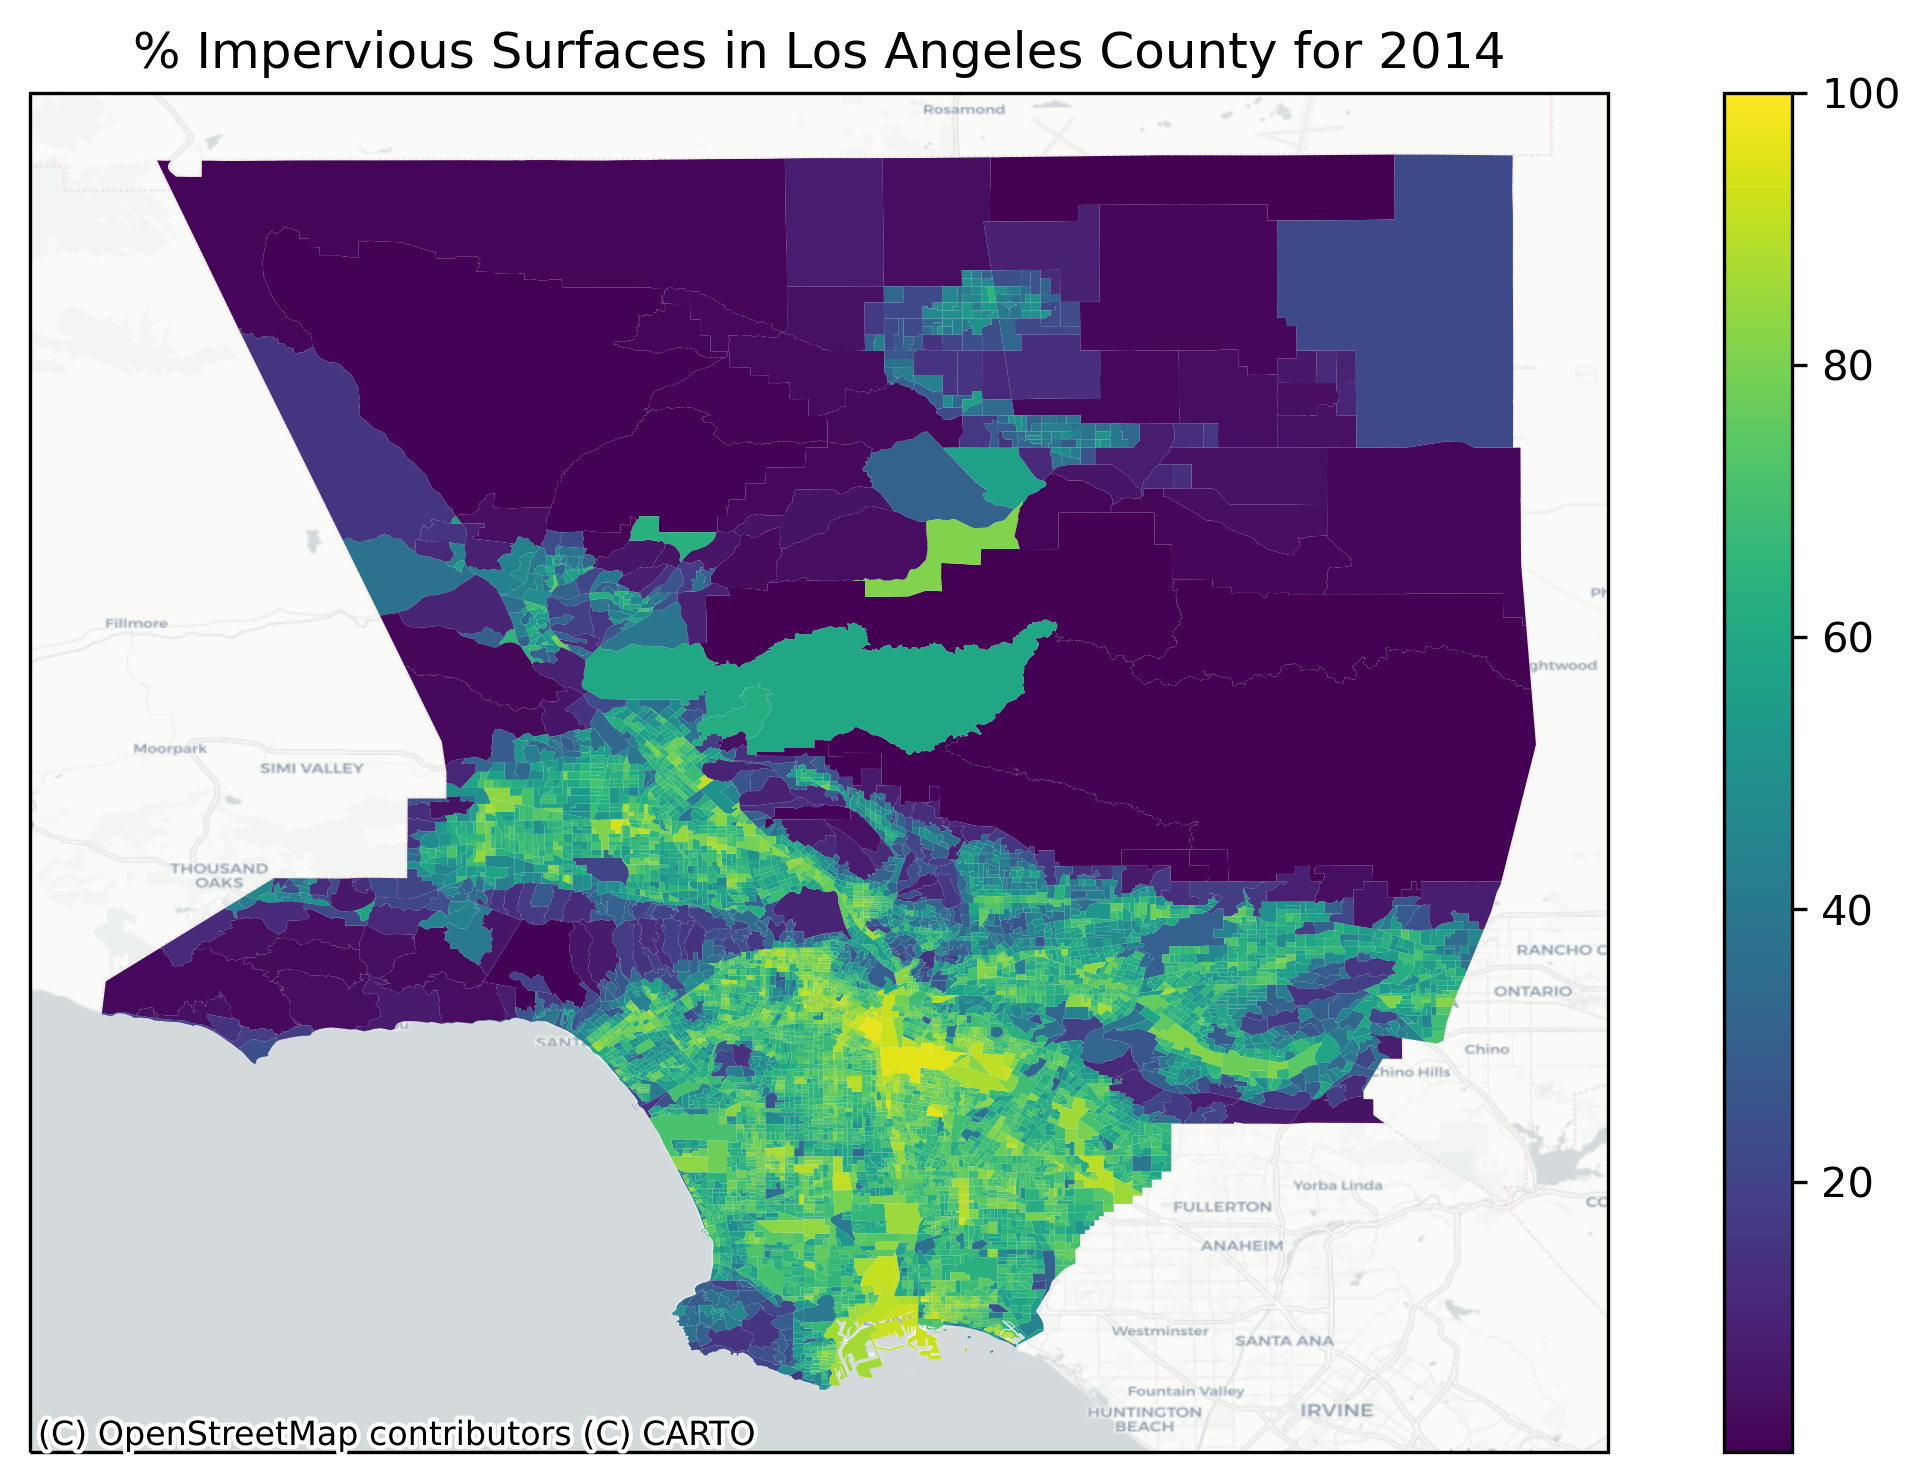

In [28]:
# Set projection to Plate Carreé
# Plot % impervious surfaces in LA County 
# Add `contextily` base map underneath 

proj = ccrs.PlateCarree()
fig = plt.figure(figsize = (10, 6), dpi = 300)
ax = plt.axes(projection = proj)

# Name AOI
AOI.plot('imperv_p', ax = ax, legend = True)

# Add basemap 
ctx.add_basemap(ax, crs = 'EPSG:4326', source = ctx.providers.CartoDB.Positron); 

# Add title and axes titles 
plt.title('% Impervious Surfaces in Los Angeles County for 2014')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

In [26]:
# Note other variables we can plot 
AOI.head()

objectid       geoid10   ctbg10    ct10  areasqmil label  fip10 fip10rv  \
0     307.0  060377029014  7029014  702901     0.8425  BG 4  45806   99037   
1     801.0  060378004101  8004101  800410    14.4154  BG 1   None   99037   
2     802.0  060378005041  8005041  800504     8.2425  BG 1   None   99037   
3     803.0  060378005062  8005062  800506     0.1243  BG 2   None   45246   
4     805.0  060379001032  9001032  900103     3.5670  BG 2  39612   99037   

           cdp_name        cityname  ...     soil_p   water_p    build_p  \
0    Marina del Rey  Unincorporated  ...   1.652731  7.599387   8.174864   
1              None  Unincorporated  ...  21.115381  0.028004   0.743893   
2              None  Unincorporated  ...  27.955007  0.495477   2.096810   
3              None          Malibu  ...  35.717506  0.478728  16.839315   
4  Lake Los Angeles  Unincorporated  ...  89.310953  0.000000   1.776818   

      road_p    paved_p    shrub_p     perv_p   imperv_p  \
0   7.376787  25.370861   3.526827  59.077489  40.922511   
1   1.977940   0.921399  38.162711  96.356768   3.643232   
2   2.966574   2.265797  32.802540  92.670819   7.329181   
3  23.767795  14.129680   0.824025  45.263210  54.736790   
4   4.333440   0.303966   1.204833  93.585777   6.414223   

                                 layer  \
0  la_county_nonurban_2010_blockgroups   
1  la_county_nonurban_2010_blockgroups   
2  la_county_nonurban_2010_blockgroups   
3  la_county_nonurban_2010_blockgroups   
4  la_county_nonurban_2010_blockgroups   

                                            geometry  
0  POLYGON ((-118.44622 33.98426, -118.44251 33.9...  
1  POLYGON ((-118.70402 34.08093, -118.70363 34.0...  
2  POLYGON ((-118.69364 34.07769, -118.69358 34.0...  
3  POLYGON ((-118.56734 34.04139, -118.56735 34.0...  
4  POLYGON ((-117.84479 34.64584, -117.84487 34.6...  

[5 rows x 50 columns]

<a id='usecase'></a> 
# Use Case Example

<a id='composite'></a> 
## Composite Map: canopy cover and redlining 
This 2014 Los Angeles County urban tree cover data is appropriate for identifying areas in LA County with relatively higher or lower tree canopy cover based on the calculated % canopy coverage. Combined with other data sets, this could help answer a variety of interesting questions. For this use case example, we are going to overlay a map of historical redlining in LA to investigate how historical inequalities might have influenced today's urban forest. Our target audience are LA policymakers and any stakeholders invovled in urban forestry. This data is particularly important for LA policymakers to consider since it has been found that tree canopy on residential parcels have been declining significantly since 1990 (Galvin et al., 2019) and we know that tree canopy provides numerous health and environmental benefits. Furthermore, this could help idenitify communities who need tree canopy the most, especially those who have been historically discriminated against. 

2. Markdown and code blocks demonstrating how one walks through the desired use case example. This should be similar to the labs we've done in class: you might want to demonstrate how to isolate a particularly interesting time period, then create an image showing a feature you're interested in, for example.

Text(0, 0.5, 'Latitude')

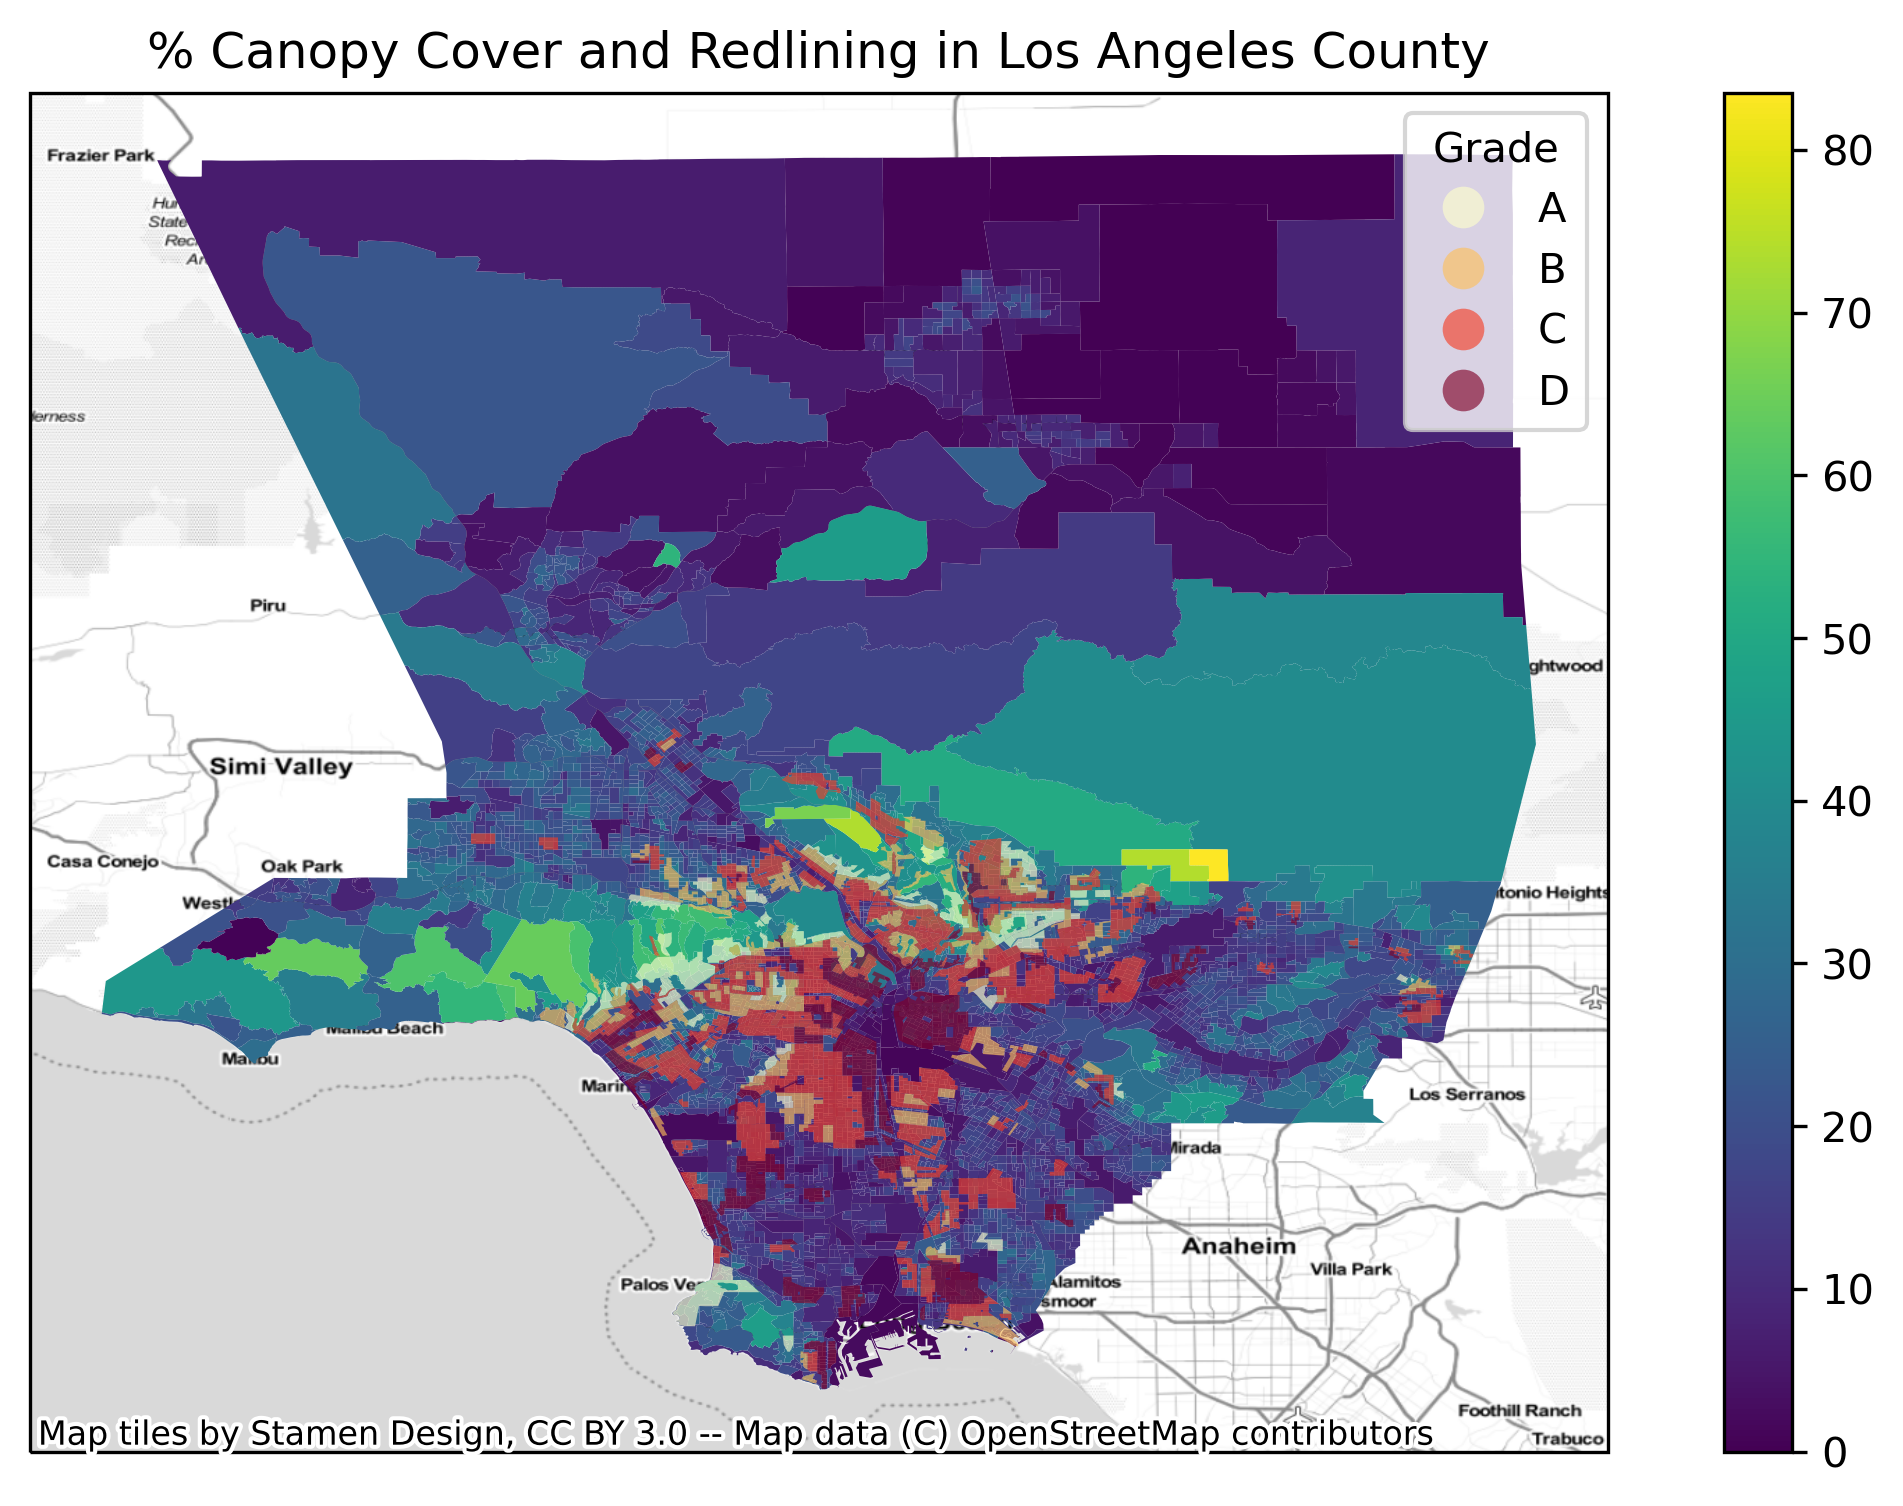

In [39]:
# Set projection to Plate Carree
proj = ccrs.PlateCarree()

# Set figure and axes 
fig = plt.figure(figsize = (10, 6), dpi = 300)
ax = plt.axes(projection = proj)

# Plot % canopy cover in LA County 
tcLA.plot(column = 'Can_P', ax = ax, legend = True)

# Plot redlining map  
red.plot(column = 'holc_grade', ax = ax, legend = True, cmap = 'YlOrRd', 
         legend_kwds = {'title': 'Grade'}, alpha = 0.63)

# Add basemap 
ctx.add_basemap(ax, crs = 'EPSG:4326', source = ctx.providers.Stamen.TonerLite); 

# Add title and axes titles 
plt.title('% Canopy Cover and Redlining in Los Angeles County')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Tree canopy cover and historical redlining are still relevant today. In 2019, Mayor Eric Garcetti released the Green New Deal - an ambitious plan to address environmental challenges in Los Angeles. The plan includes two primary urban forestry goals: plant 90,000 trees by 2021 and increase tree canopy in areas of greatest need by at least 50% by 2028 (Garcetti 2019). As of September 2021, over 52,000 trees have been planted (Lopez & Drechsler, 2021). With approximately 40,000 trees to be planted, we could check the progress of these goals by comparing 2014 tree canopy data with the most up-to-date data. Additionally, we could compare recent tree canopy data with historical redlining to see if current tree planting efforts are considering historical discrimination.


- mapping historical native tree species

# Deleted Bits

This gives a snapshot of what tree canopy cover looked like during this year. 

For example, we could compare 2014 LA County tree cover with socioeconomic data such as 2014 annual average/median income or ethnicity/race to determine if there are correlations between greenery in LA and socioeconomic status. 

today's built environment. 

In addition to comparing various data within the same year, we could overlay a map of historical redlining in LA to investigate how historical inequalities might have influenced today's built environment. Similarly, we could compare tree canopy cover data in LA County from a different year to explore changes over time. For instance, if a tree policy was enacted after 2014, we could compare 2014 and 2020 tree canopy cover data to see if there was an observable change in % canopy cover in response to the policy enactment.

this data use case example could be updated the most up-to-date % canopy cover data 

still overlay with the historical redlining map. 

could be used to determine which areas are in highest need of tree canopy considering modern tree canopy data and historical redlining. Our target users and audience would be organizations and communities who are stakeholders in tree planting efforts, and the City of LA's Green New Deal pLAn team. 


A discussion of the results and how they might be extended on further analysis. For example, we are doing El Nino/La Nina composites in class; a natural extension might be to look at individual events to see what their particular impacts were. Or if there are data quality issues which impact the results, you could discuss how these might be mitigated with additional information/analysis.

The **Tree Canopy in Urban and Non-Urban LA County (2014)** dataset we downloaded from LA County's Open Data site is a combination of two datasets:

1. LA County tree canopy data from TreePeople and the University of Vermont.
2. 2014 imagery of LA County land cover data from the Los Angeles Regional Imagery Acquistion Consortium (LARIAC).

There is more data collection information and metadata about the land cover data than there is about the tree canopy data. We have reached out to the data owners requesting more metadata, but have not received a response yet. 

Additionally, the data set was combined with census tract data. 

The tree canopy data used high-resolution remote sensing data to create fine scale 8-class land cover. From the 2015 *Tree Canopy Assessment: Los Angeles Coastal Zone* report, it appears high resolution land cover data from 2014 was combined with LiDAR data from 2009 to obtain inforamation about the structure of urban forests. With this data, individual trees could be detected (i.e. as small as 8ft) and it is currently the most accurate accounting of tree canopy ever completed for LA.

Because there is limited metadata on the tree canopy data that was acquired using LiDAR, we can not determine if there is any systematic biases or limitation from the instruments used for the LiDAR data. 

The land cover data comes from the LARIAC which is a program for obtaining digital aerial imagery data in collaboration with 30+ County departments, 40+ municipalities, and other public agencies. Since the data is used for multiple and varying reasons for numerous agencies, the data is of high quality and is easily accessible. 

LARIAC captures ortho and oblique imagery every 3 years. Ortho imagery removes the effects of tilt and relief to show the true features of the image. Oblique imagery is aerial photography that is collected at an angle (usually 40 or 50 degrees) which allows viewers to see the sides of objects in addition to the top of objects and gives a more natural viewing of the landscape. 

Collection and post-processing of the LARIAC land cover data was done by the company, EagleView. The processed imagery produced a 4-band (RGBNIR), 32-bit (8-bit per channel) digital orthophotos at 4-inch and 9-inch pixel resolution for project areas with no overlap between areas. The 4 x 9 inch pixels were color balanced independently. 

After post-processing, the imagery undergoes rigorous quality assurance and quality control by Dewberry Engingeers Inc. From the QA/QC report we did not see any systematic biases or limitations listed about the instruments.


The most significant limitation with the **Tree Canopy in Urban and Non-Urban LA County (2014)** dataset is that it is outdated. Both datasets are more than 5 years old. However, LARIAC land cover data has been udpated with 2020 data and it is possible for us to combine tree canopy data with the 2020 land cover data.

<a id='binder'></a> 
# Binder Environment
[README launch binder link](https://github.com/la-tree/notebook#readme)

<a id='references'></a> 
# References

1. Galvin, Mike, et al. Los Angeles County Tree Canopy Assessment. SavATree Consulting Group, 24 Apr. 2019, https://www.treepeople.org/wp-content/uploads/2020/08/Tree-Canopy-LA-2016-Final-Report.pdf.
2. Garcetti, Mayor Eric. L.A.’s Green New Deal: Sustainable City PLAn. 2019, p. 152.
3. Grove, J. M., & Locke, D. (2011). Urban Tree Canopy Prioritization (UTC). Nature Precedings. https://doi.org/10.1038/npre.2011.6368.1
4. Krieger, N., Van Wye, G., Huynh, M., Waterman, P. D., Maduro, G., Li, W., Gwynn, R. C., Barbot, O., & Bassett, M. T. (2020). Structural Racism, Historical Redlining, and Risk of Preterm Birth in New York City, 2013–2017. American Journal of Public Health, 110(7), 1046–1053. https://doi.org/10.2105/AJPH.2020.305656
5. Lopez, L., & Drechsler, P. “One Tree at a Time: LA Cooling Underprivileged Urban Areas.” NBC Los Angeles, 22 Sept. 2021, https://www.nbclosangeles.com/news/local/one-tree-at-a-time-la-cooling-underprivileged-urban-areas/2698849/. Accessed 16 Nov. 2021.
6. Nardone, A., Rudolph, K. E., Morello-Frosch, R., & Casey, J. A. (2021). Redlines and Greenspace: The Relationship between Historical Redlining and 2010 Greenspace across the United States. Environmental Health Perspectives, 129(1), 017006. https://doi.org/10.1289/EHP7495
7. Nelson, R.K., Winling L., Marciano R., Connolly N., et al., “Mapping Inequality,” American Panorama, ed. Robert K. Nelson and Edward L. Ayers, accessed November 15, 2021, https://dsl.richmond.edu/panorama/redlining/#loc=5/39.1/-94.58&text=downloads.
8. Oke, T. R. (1981). Canyon geometry and the nocturnal urban heat island: Comparison of scale model and field observations. Journal of Climatology, 1(3), 237–254. https://doi.org/10.1002/joc.3370010304

